In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy.stats import loguniform, uniform, randint

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier

In [5]:
data_train = pd.read_csv('cs-training.csv')
data_test = pd.read_csv('cs-test.csv')
# data_train = np.loadtxt('cs-training.csv', delimiter=',', skiprows=1)

In [ ]:
# print(data_train.iloc[1])
print(data_train['age'])
print(data_train['MonthlyIncome'])

In [ ]:
plt.figure()
plt.hist(data_train['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение возраста заёмщиков')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', alpha=0.5)
plt.show()

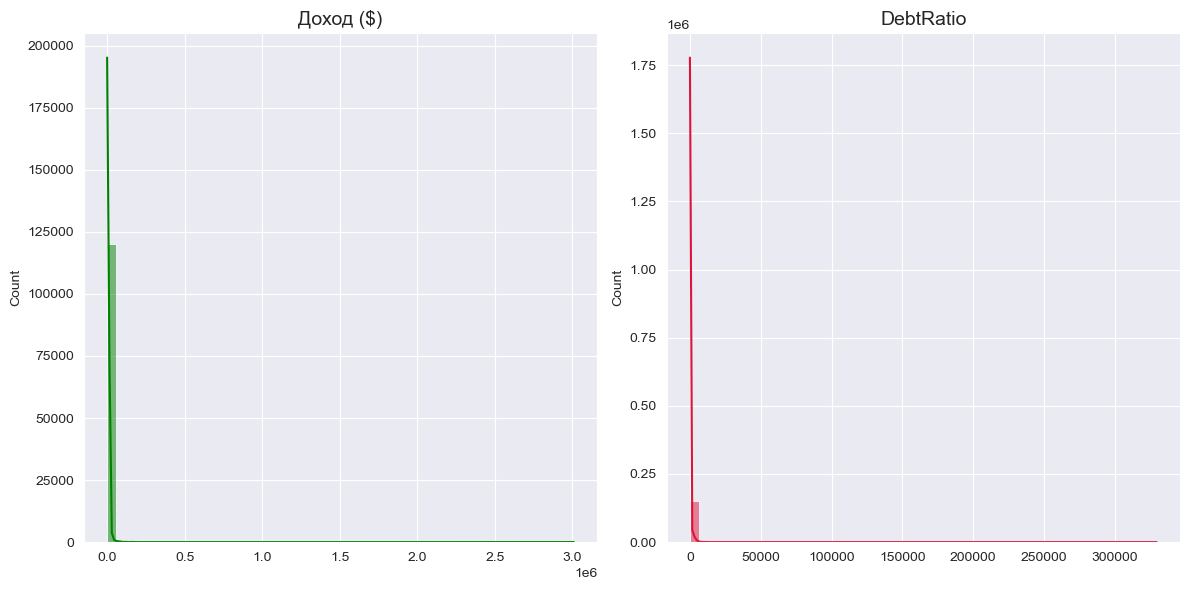

In [6]:
plt.figure(figsize=(12, 6))

# Доход (MonthlyIncome)
plt.subplot(1, 2, 1)
sns.histplot(data_train['MonthlyIncome'].dropna(), bins=50, color='green', kde=True)
plt.title('Доход ($)', fontsize=14)
plt.xlabel('')

# Долг (DebtRatio)
plt.subplot(1, 2, 2)
sns.histplot(data_train['DebtRatio'], bins=50, color='crimson', kde=True)
plt.title('DebtRatio', fontsize=14)
plt.xlabel('')

plt.tight_layout()
plt.show()

Из графиков выше видим наличие выбросов

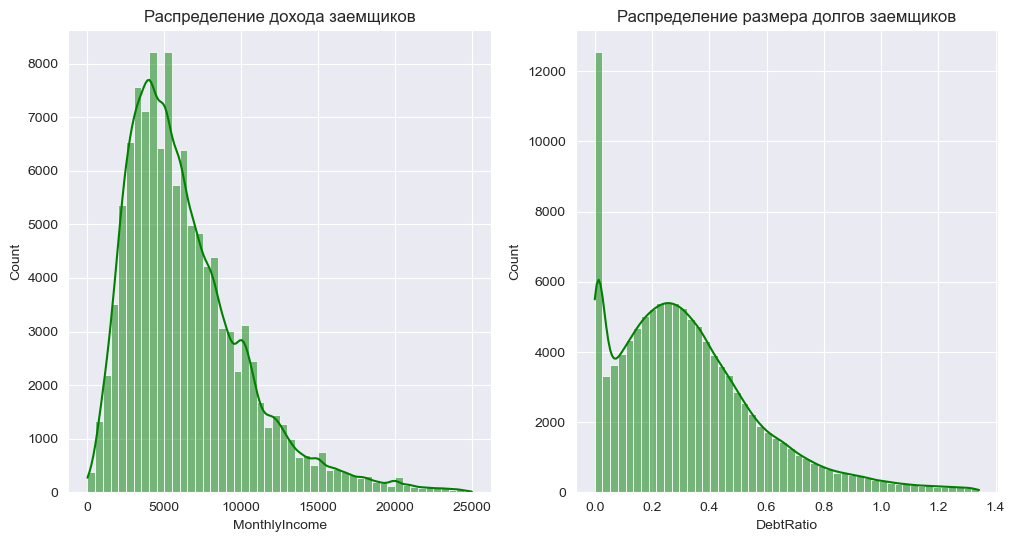

<Figure size 640x480 with 0 Axes>

In [142]:
# Отсечение выбросов (обрезка)
# 99% значений доходов оставляю, и один процент отсекаю
# 80% значений долгов оставляю
data_train_clean = data_train[data_train['MonthlyIncome'] < data_train['MonthlyIncome'].quantile(0.99)]
data_clean = data_train_clean[data_train_clean['DebtRatio'] < data_train_clean['DebtRatio'].quantile(0.96)] 


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_clean['MonthlyIncome'], bins=50, color='green', kde=True)
plt.title('Распределение дохода заемщиков')


plt.subplot(1, 2, 2)
sns.histplot(data_clean['DebtRatio'], bins=50, color='green', kde=True)
plt.title('Распределение размера долгов заемщиков')
plt.show()

plt.tight_layout()

Восполним пропуски в данных:

Количество пропусков в каждом столбце:
Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


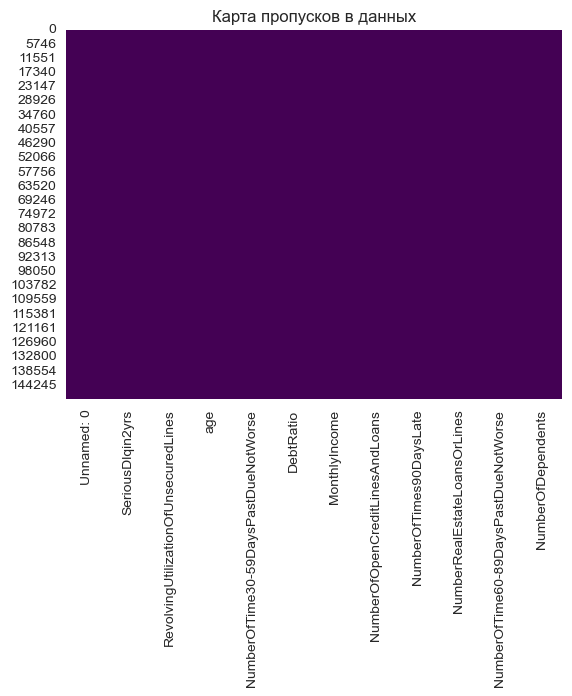

In [143]:
print("Количество пропусков в каждом столбце:")
print(data_train_clean.isnull().sum())

sns.heatmap(data_train_clean.isnull(), cbar=False, cmap='viridis')
plt.title("Карта пропусков в данных")
plt.show()

Number of dependents in family excluding themselves (spouse, children etc.) - integer --> заполнение модой

Monthly income - real --> заполнение средним

Сверху визуализация заполненных (незаполненных) пропусков.

В библиотеке sklearn для предобработки данных есть подходящие методы, воспользуемся ими.

In [144]:
X_test = pd.read_csv('cs-test.csv').drop(['SeriousDlqin2yrs'], axis=1)

y = pd.read_csv('sampleEntry.csv')
y_test = y['Probability']

X_train = data_clean.drop(['SeriousDlqin2yrs'], axis=1)
y_train = data_clean['SeriousDlqin2yrs']

In [145]:
# Создаём трансформеры для разных типов признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['MonthlyIncome']),  # числа → среднее
        ('cat', SimpleImputer(strategy='most_frequent'), ['NumberOfDependents'])  # категории → мода
    ])

# Добавляем масштабирование
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()) 
])

In [146]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Попробуем разные модели:

Логистическая регрессия

In [153]:
model = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', C=618.7736959637081)
model.fit(X_train_processed, y_train)

LogisticRegression(C=618.7736959637081, max_iter=1000, penalty='l1',
                   solver='liblinear')

Попробуем кросс-валидацию для модели логистической регрессии, что бы подобрать лучшие гиперпараметры

In [101]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # сила регуляризации (обратная величина)
    'penalty': ['l1', 'l2'],   # тип регуляризации (L1/L2)
    'solver': ['liblinear']    # алгоритм для L1/L2
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Лучшая accuracy: 0.5996572389330626


In [158]:
param_dist = {
    'C': loguniform(1e-3, 1e3),  # сила регуляризации (от 0.001 до 1000)
    'penalty': ['l1', 'l2'],      # тип регуляризации
    'class_weight': [None, 'balanced', {0:1, 1:5}],  # веса классов
    'solver': ['liblinear', 'saga']  # алгоритмы, поддерживающие L1/L2
}

model = LogisticRegression(max_iter=1000)

# Стратифицированная кросс-валидация (5 фолдов)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # количество случайных комбинаций
    cv=cv,
    scoring='roc_auc',  
    n_jobs=-1,  # использовать все ядра CPU
    random_state=42,
    verbose=1
)

random_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучшая оценка:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'C': 2.5480149212968444, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Лучшая оценка: 0.6063432169262407


Случайный лес

In [90]:
model = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=2)
model.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50)

Попробуем кросс-валидацию для модели случайного леса, что бы подобрать лучшие гиперпараметры

In [88]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv=5 — кросс-валидация на 5 фолдах
grid_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


XGBoost

In [163]:
model = XGBClassifier(
    scale_pos_weight=1,  # Баланс классов
    eval_metric="auc",
    n_estimators=165,
    max_depth=3,
    learning_rate=0.016034047398805644,
    subsample=0.7675681414781061,
    colsample_bytree=0.8123538802630876,
    reg_alpha=0.9295515807202052,
    reg_lambda=0.17556041585306104,
)
model.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8123538802630876, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.016034047398805644,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=165, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [159]:
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),  # от 0.01 до 0.31
    "subsample": uniform(0.7, 0.3),       # от 0.7 до 1.0
    "colsample_bytree": uniform(0.7, 0.3),
    "reg_alpha": uniform(0, 1),           # от 0 до 1
    "reg_lambda": uniform(0, 1),
    "scale_pos_weight": [1, 5, 10]        # для дисбаланса
}

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,           # Количество комбинаций
    scoring="roc_auc",   # Метрика (AUC)
    cv=5,                # Кросс-валидация
    n_jobs=-1,           # Использовать все ядра
    verbose=1
)

search.fit(X_train_processed, y_train)

print("Лучшие параметры:", search.best_params_)
print("Лучший AUC:", search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'colsample_bytree': 0.7512061462590821, 'learning_rate': 0.01322678096970852, 'max_depth': 5, 'n_estimators': 111, 'reg_alpha': 0.5622954634802614, 'reg_lambda': 0.9963678657720526, 'scale_pos_weight': 10, 'subsample': 0.7930738515377942}
Лучший AUC: 0.6073709254718425


In [171]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 10,
    'gamma': 0.3,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'seed': 42
}


model = XGBClassifier(**params)
model.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Stacking

In [150]:
estimators = [
    ("xgb", XGBClassifier(scale_pos_weight=10, eval_metric="auc")),
    ("rf", RandomForestClassifier(class_weight="balanced"))
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train_processed, y_train)

KeyboardInterrupt: 

In [172]:
y_pred = model.predict_proba(X_test_processed)[:, 1]

print(y_pred[y_pred > 0.5])

y_test_binary = (y_test > 0.5).astype(int)

[0.55350846 0.56333786 0.5594734  ... 0.5929644  0.57018375 0.5586736 ]


Оценка точности модели:

AUC-ROC: 0.6405


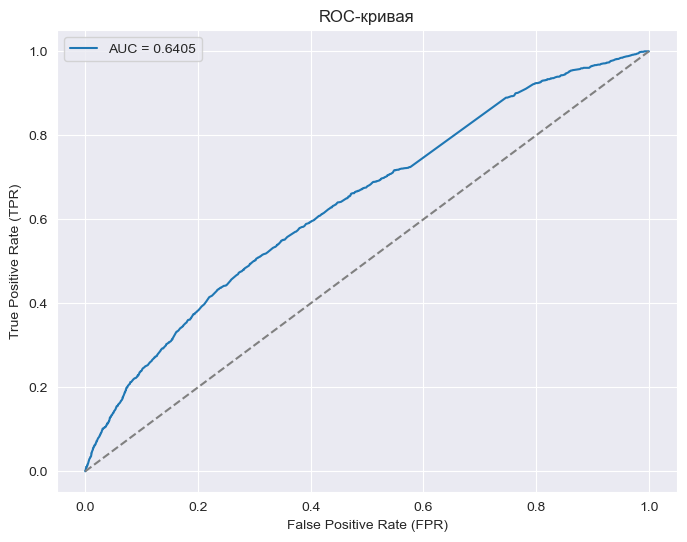

In [173]:
# Вычисляем AUC-ROC
auc = roc_auc_score(y_test_binary, y_pred)
print(f"AUC-ROC: {auc:.4f}")

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Модели не показывают хороших результатов, попробуем создать новые признаки

In [169]:
X_train['PaymentToIncome'] = X_train['MonthlyIncome'] / (X_train['DebtRatio'] + 1e-6)
X_train['TotalPastDue'] = X_train['NumberOfTime30-59DaysPastDueNotWorse'] + \
                      X_train['NumberOfTime60-89DaysPastDueNotWorse'] + \
                      X_train['NumberOfTimes90DaysLate']
X_train['IsOverdue'] = (X_train['TotalPastDue'] > 0).astype(int)

X_test['PaymentToIncome'] = X_test['MonthlyIncome'] / (X_test['DebtRatio'] + 1e-6)
X_test['TotalPastDue'] = X_test['NumberOfTime30-59DaysPastDueNotWorse'] + \
                      X_test['NumberOfTime60-89DaysPastDueNotWorse'] + \
                      X_test['NumberOfTimes90DaysLate']
X_test['IsOverdue'] = (X_test['TotalPastDue'] > 0).astype(int)

In [170]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)